## Code for example 3.2 in the paper :

* Autor : F. Sahli 2023
* Editado por : Allen A. G. Junio 2025
* Github : https://github.com/fsahli/Delta-PINNs

# librerias y github

In [1]:
# Clonamos el github, creo que se hace cada vez que se entra al colab
# Por ejemplo se utiliza para : from jaxpinns.base import PINN
!git clone https://github.com/fsahli/Delta-PINNs.git

fatal: destination path 'Delta-PINNs' already exists and is not an empty directory.


In [2]:
# Se hace cada vez que se entra al colab para utilizar las carpetas del github

import sys
sys.path.append('/content/Delta-PINNs')

In [3]:
# Si dice : 0.6.1 o algo similar está bien

import jax
print(jax.__version__)

0.5.2


In [4]:
from jaxpinns.base import PINN # PINN es del github
%load_ext autoreload
%autoreload 2
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax._src.config import config  # <- Esto cambio respecto a 2022. Antes era : from jax.config import config
from scipy.linalg import eigh
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

from jax import random, grad, jit, vmap
from jax.tree_util import Partial as partial
from jax.ops import segment_sum
import jax
from jax.scipy.optimize import minimize
import numpy as onp
#from jax.experimental import optimizers

In [5]:
# Estas librerías tenían problemas

# from pyDOE import lhs     # arreglado
# import igl
# import meshio             # arreglado

In [6]:
!pip install pyDOE2
!pip install meshio

In [7]:
# pip install pyigl scipy # no corre en colab, se reemplaza por otra librería

In [8]:
from pyDOE2 import lhs
import meshio
from Mesh import Mesh

import jax.numpy as np
from jax import random, grad, vmap, jvp

from jaxpinns.samplers import Sampler
from jax.example_libraries import optimizers


from jaxpinns.architectures import MLP
from jaxpinns.optimizers import adam
from jaxpinns.loggers import logger

import matplotlib.pyplot as plt

from torch.utils import data

import scipy.sparse    # Para trabajar con matrices dispersas
from scipy.sparse.linalg import spsolve

onp.random.seed(1234)
rng_key = random.PRNGKey(0)

import time

# Cargar malla del github o mallas guardadas, etc

In [9]:
mvtu = meshio.read('/content/Delta-PINNs/data/convection000000.vtu')

In [10]:
mvtu.cells_dict['triangle']

array([[ 161,  926,  927],
       [ 352,  992,  993],
       [ 108,  472, 1235],
       ...,
       [ 510,  511, 1287],
       [ 400,  494, 1288],
       [ 287,  494, 1288]])

In [11]:
verts = mvtu.points
connectivity = mvtu.cells_dict['triangle']

In [12]:
# 1289 nodos y 2183 triangulos
verts.shape,connectivity.shape

((1289, 3), (2183, 3))

In [13]:
# del tipo x_i = [1,1,0] ejemplo.
verts

array([[1.        , 1.        , 0.        ],
       [0.8       , 1.        , 0.        ],
       [0.8       , 0.2       , 0.        ],
       ...,
       [1.        , 0.203125  , 0.        ],
       [0.57870502, 0.23337771, 0.        ],
       [0.81715718, 0.2375    , 0.        ]])

In [14]:
# El primer triangulo de la malla esta formado por los vertices 161,926,927
connectivity

array([[ 161,  926,  927],
       [ 352,  992,  993],
       [ 108,  472, 1235],
       ...,
       [ 510,  511, 1287],
       [ 400,  494, 1288],
       [ 287,  494, 1288]])

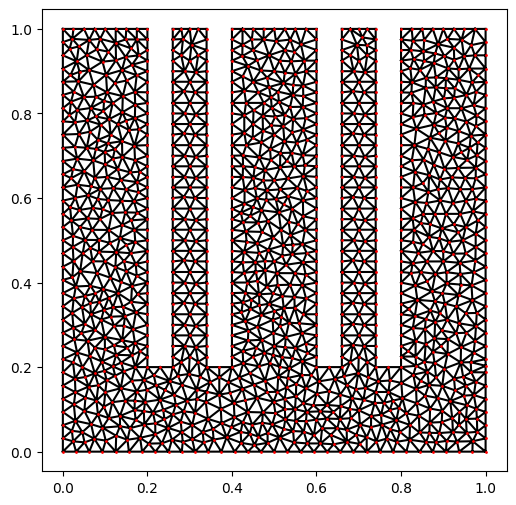

In [15]:
#vizualización del mallado :

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# Coordenadas 2D
x = verts[:, 0]
y = verts[:, 1]

# Crear triangulación
triang = mtri.Triangulation(x, y, connectivity)

# Graficar
plt.figure(figsize=(6, 6))
plt.triplot(triang, color='black')
plt.scatter(x, y, s=1, color='red')
plt.axis('equal')
plt.show()

# Calcular los vectores propios y matriz laplaciana

In [16]:
# Se calculan los vectores propios desde el archivo Mesh
m = Mesh(verts = verts, connectivity = connectivity)

In [17]:
print('Computing Laplacian')
K, M = m.computeLaplacian()
print('Computing eigen values')

eigvals, eigvecs = eigh(K,M)

Computing Laplacian
Computing eigen values


Text(0.5, 0, 'Índice del valor propio')

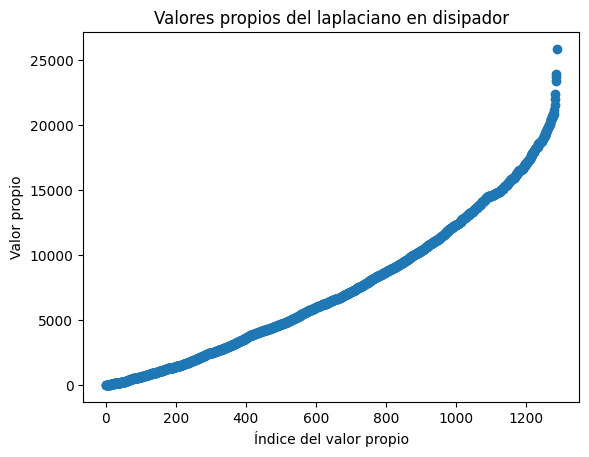

In [18]:
plt.scatter(range(len(eigvals)), eigvals)
plt.title("Valores propios del laplaciano en disipador")
plt.ylabel("Valor propio")
plt.xlabel("Índice del valor propio")

In [19]:
eigvecs

array([[-7.86645969e-01,  1.32474732e+00, -1.06133198e+00, ...,
         3.11521391e-17, -8.79362728e-16, -1.35407093e-16],
       [-7.86645969e-01,  1.32465110e+00, -1.06120094e+00, ...,
        -1.72044780e-15, -2.31165367e-14,  2.04796151e-14],
       [-7.86645969e-01,  6.10788308e-01, -1.54413059e-01, ...,
        -9.62465057e-13, -1.41233293e-15, -1.27973905e-13],
       ...,
       [-7.86645969e-01,  7.34568966e-01, -3.01524376e-01, ...,
         2.85684290e-15, -4.36862620e-15, -6.97217596e-15],
       [-7.86645969e-01,  6.03738132e-02,  4.81613758e-01, ...,
        -2.09337230e-12,  3.28638237e-15, -1.43005203e-13],
       [-7.86645969e-01,  7.19387811e-01, -2.84751915e-01, ...,
         9.86563458e-13, -4.94484255e-15, -6.43266859e-16]])

In [20]:
eigvecs[:, 0] # es columna 0

array([-0.78664597, -0.78664597, -0.78664597, ..., -0.78664597,
       -0.78664597, -0.78664597])

In [21]:
eigvecs[0, :] # es fila 0

array([-7.86645969e-01,  1.32474732e+00, -1.06133198e+00, ...,
        3.11521391e-17, -8.79362728e-16, -1.35407093e-16])

In [22]:
eigvecs[0] # es la fila no la columna

array([-7.86645969e-01,  1.32474732e+00, -1.06133198e+00, ...,
        3.11521391e-17, -8.79362728e-16, -1.35407093e-16])

In [23]:
eigvecs.shape # tienes la misma cantidad(1289) de eigvecs que de nodos, y cada eigvecs tiene largo 1289

(1289, 1289)

# Duda con linea de codigo en  LaplacePINN(PINN) (Resuelta)

Qué hace lo siguiente en LaplacePINN(PINN) el siguiente codigo ?


```
self.Xc = self.eigenfuncs[self.connectivity.flatten(),:]
```

En $eigvecs$ tenemos los vectores propios como columas, donde cada fila representa un nodo. luego solo escogemos $n_{eigs} $ vectores propios.

Esto se realiza de la siguiente forma :



In [24]:
# ejemplo, tenemos dos vectores propios de largo(en columna) a 1289
# esto sirve pues cada coordenada del vector propio está asociado a un nodo de la malla :

n_eigs=2
eigfuncs = eigvecs[:,:n_eigs]
eigfuncs.shape

(1289, 2)

In [25]:
# Luego tenemos el siguiente ejemplo que contiene dos vectores propios para 4 nodos:

vec_propios = np.array([
    [10, 11],  # nodo 0
    [20, 21],  # nodo 1
    [30, 31],  # nodo 2
    [40, 41],  # nodo 3
])
# la conectividad son los triangulos definidos por el indice del nodo :

connectividad = np.array([
    [0, 1, 2],
    [1, 3, 0],
])

In [26]:
# es el 1er vector propio :
vec_propios[:,0]

Array([10, 20, 30, 40], dtype=int64)

In [27]:
# valores de los dos vectores en el nodo i=1
vec_propios[1]

Array([20, 21], dtype=int64)

In [28]:
# se aplana connectividad y luego se almacena los valores de los vectores propios v_j (j \in {0,1}) de la posición i del nodo x_i.
# es decir para cada x_i de connectividad guardamos v_j[i]
vec_propios[connectividad.flatten(),:]

Array([[10, 11],
       [20, 21],
       [30, 31],
       [20, 21],
       [40, 41],
       [10, 11]], dtype=int64)

# Pasar matriz numlap a .tolil() (si no hay problemas con el codigo )

In [29]:
# Kigl = igl.cotmatrix(m.verts, m.connectivity.astype(int)) # Calculando la matriz de rigidez dispersa Kigl.
# Migl = igl.massmatrix(m.verts, m.connectivity.astype(int))
# El formato .lil es el único de SciPy que tiene las propiedades .rows y .data usadas por tu LaplacePINNGenerator
# permite acceder a:
# numlap.rows[i]   # lista de columnas no cero en la fila i
# numlap.data[i]   # lista de valores correspondientes en la fila i
# numlap = Kigl.tolil()

In [30]:
from scipy.sparse import lil_matrix
#K, M = m.computeLaplacian()  # Usas tu propia malla
numlap = lil_matrix(K)       # Convierte a formato lil

# Clase Detla - PINNS  y generadora de datos

In [80]:

def f(x) :
  return x**2 +1
f_vmap = vmap(f)
arreglo = np.array([1, 2, 3])
f_vmap(arreglo)

Array([ 2,  5, 10], dtype=int64)

In [79]:
def f(x):
    return x**2 + 1

arreglo = np.array([[1, 2, 3], [1, 2, 3]])  # shape (2, 3)
f_vmap = vmap(f)
f_vmap(arreglo)


Array([[ 2,  5, 10],
       [ 2,  5, 10]], dtype=int64)

In [100]:
def u_red(x):
    y = jax.numpy.stack([x])
    return y[0][0]

X = np.array([[-0.78664597,  1.32474732],
       [-0.78664597,  0.06037381],
       [-0.78664597,  0.61078831]])
u_pred = vmap(u_red)(X)
u_pred

Array([-0.78664597, -0.78664597, -0.78664597], dtype=float64)

In [94]:
u_red(np.array([0.5]))

Array(0.5, dtype=float64)

In [95]:
u_red(np.array([4, 2, 3]))

Array(4, dtype=int64)

In [96]:
u_red(np.array([[0.5, 0.1, 0.2], [4, 16, 32]]))

Array([0.5, 0.1, 0.2], dtype=float64)

In [112]:
Y_borde =Y[np.array([0,1,2])]
Y_borde

array([-0.5936783 , -0.59356999,  1.08624254])

In [122]:
def u_red(x):
    y = jax.numpy.stack([x])
    return y[0][0]

Y_borde = np.array([1,2,3])
Y_borde

u_pred = vmap(u_red)(X)
u_pred

X = np.array([[0,  0],
       [0,  0],
       [1, 0]])
X

u_pred = vmap(u_red)(X)
loss_u = np.mean((u_pred-Y_borde)**2)
loss_u

Array(3., dtype=float64)

In [67]:
class LaplacePINN(PINN):
     #
     # dataset = LaplacePINNGenerator(np.array(V), np.array(Y), eigfuncs, numlap, idx_c, batch_size=30)
     # model = LaplacePINN(eigfuncs, m.connectivity, Bs, norm_const)

    # Initialize the class
    def __init__(self, eigenfuncs, connectivity, mesh_operator, norm_const, mu_X = 0.0, sigma_X = 1.0):
        super().__init__(mu_X, sigma_X)

        self.eigenfuncs = np.array(eigenfuncs)
        self.connectivity = connectivity
        self.mesh_operator = mesh_operator
        # flatten aplana el vector  connectivity de dimension (2183, 3) a un arreglo de 2183x3 valores
        # eigenfuncs es eigvecs(eigvecs.shape = 1289, 1289) pero con 50 vectores propios de largo 1289(igual al numero de nodos)
        # eigenfuncs[self.connectivity.flatten(),:] está haciendo una indexación fila a fila sobre eigenfuncs, que es de forma (1289, 50).
        # Xc es un arreglo de arreglos que contiene para cada nodo i de connectivity.flatten() los valores de los eigenfuncs en la coordenada i
        # es decir, Xc = [[-0.4,...,-0.1],...,[-0.75,...,-0.34]] donde [-0.4,...,-0.1] corresponde a los 50 valores en la coordeana 1 de cada eigenfuncs
        # [-0.4,...,-0.1] = [eigenfuncs[1][1],...,eigenfuncs[50][1]] donde estamos en el nodo 1
        # [-0.75,...,-0.34] =  [eigenfuncs[1][50],...,eigenfuncs[50][50]]

        self.Xc = self.eigenfuncs[self.connectivity.flatten(),:]

        self.mu_y = norm_const['mu_y']
        self.sigma_y = norm_const['sigma_y']
        self.num_loss_terms = 2

    # Make sure this accepts a single input data-point and returns a scalar!
    # Then use vmap to vectorize
    '''
    Red para solo una unica entrada x , se utiliza net_apply
    '''
    def net_u(self, params, x):
        inputs = jax.numpy.stack([x]) # antes era np.stack([x])
        u = self.net_apply(params, inputs)
        return u[0][0] # devuelve un escalar, que es la predicción

    '''
    Durante el preprocesamiento, los datos de salida suelen normalizarse:
            Y = (Y_original - mu_y) / sigma_y

    Por lo tanto, la red neuronal aprende a predecir Y normalizado. Para obtener la predicción real, debemos desnormalizar:
            Y_original = Y_pred * sigma_y + mu_y

    Calcula el gradiente de net_u respecto a x y se desnormaliza por : net_u*sigma_y.
            Si u_normalizado = (u_real - mu_y)/sigma_y, entonces:
                   du/dx = d(u_normalizado)/dx * sigma_y
    '''

    def net_r(self, params, x):
        u_v = grad(self.net_u, 1)(params, x)*self.sigma_y
        return u_v
    # inputs  = (self.V[idx], self.Vc[nodes], np.array(vals), np.array(segments))
    # outputs = (self.Y[idx], np.zeros((self.batch_size,1))) # Y[idx] valores conocidos de la solucion.
    @partial(jit, static_argnums=(0,))
    def loss_u(self, params, batch):
        # Fetch data
        inputs, targets = batch
        # V = eigfuncs[~boundary_mask]
        # X = V[idx], el arreglo de vectores propios en el borde para los indices idx(asociados a los nodos)
        X, _, _, _ = inputs # Es una forma de desempaquetar la tupla inputs ignorando algunos de sus elementos. X = V[idx]
        Y, _ = targets # Y la data conocida en el borde
        # Evaluate model
        u_fn = lambda x: self.net_u(params, x)

        # f_vmap = vmap(f) . Si f es una funcion puntual como f(x) = x**2 +1
        # result = f_vmap(jnp.array([1, 2, 3]))  # Resultado: [2, 5, 10]
        u_pred = vmap(u_fn)(X) # vmap vectoriza net_u para evaluar múltiples puntos

        # Compute loss
        loss_u = np.mean((Y - u_pred)**2)
        return loss_u

    #### Es importante u_pred = vmap(u_fn)(X), pues resive X = V[idx], el arreglo de vectores propios en el borde para los indices idx(asociados a los nodos)

    '''
    Pérdida para el cumplimiento de la PDE (parte física)

    jit: Compilación Just-In-Time de JAX para acelerar la ejecución.
    static_argnums=(0,): Indica que el primer argumento (self) debe tratarse como estático (no se diferencia).

    Idea :
       1. La red neuronal aproxima u ≈ NN(x)
       2. Calculamos el Laplaciano discreto: ∇²u ≈ L·u (matriz L aplicada a u), para L dispersa se hace :
          Seleccionar vecindades (connectivity)
          Aplicar pesos (vals)
          Sumar contribuciones (segment_sum)
      3. Queremos minimizar ||∇²u||² = ||L·u||²
    '''

    @partial(jit, static_argnums=(0,))
    def loss_r(self, params, batch):
        # Fetch data
        # inputs  = (self.V[idx], self.Vc[nodes], np.array(vals), np.array(segments))
        # V_res = Vc[nodes], donde Vc[nodes] se define por : Vc = eigfuncs Todas las funciones propias. con nodes nodos del interior escogidos aleatoriamente
        inputs, targets = batch
        _, V_res, vals, segments = inputs # V_x (batch_size, n_eig, 3), V_xx: (batch_size, n_eig)
        _, Y_res = targets
        # vmap : Vectoriza net_u para evaluar múltiples puntos en paralelo.
        # in_axes=(None,0) : No vectoriza params (None), pero sí sobre V_res (eje 0)
        u_res = vmap(self.net_u, in_axes=(None,0))(params, V_res)*self.sigma_y + self.mu_y # se desnormaliza

        # segment_sum: Suma agrupada equivalente a una multiplicación matricial dispersa
        # 30: Número máximo esperado de segmentos (dimensionamiento para compilación)
        res = segment_sum(u_res*vals, segments, 30)

        # Compute loss, Promedia el error sobre todos los puntos
        # segments[-1] + 1 equivale al número de puntos de colocación (batch size)
        # res**2 penaliza desviaciones
        loss_r = np.sum(res**2)/(segments[-1] + 1)
        return loss_r

    def loss(self, params, batch, weights=(1.0,1.0)):
        w_u, w_r = weights
        loss_u = self.loss_u(params, batch)
        loss_r = self.loss_r(params, batch)
        loss = w_u*loss_u + w_r*loss_r
        return loss

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict(self, params, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        u_fn = lambda x: self.net_u(params, x)
        u_star = vmap(u_fn)(X_star)
        return u_star

'''
LaplacePINNGenerator :

Hereda de data.Dataset, lo que significa que está diseñada para trabajar con pipelines de datos en frameworks como JAX o PyTorch.
Su propósito es generar batches de datos para entrenar una PINN que resuelva ecuaciones diferenciales parciales (PDEs) de tipo Laplace.

'''
## LaplacePINNGenerator(np.array(V), np.array(Y), eigfuncs, numlap, idx_c, batch_size=30)
class LaplacePINNGenerator(data.Dataset):
    def __init__(self, V, Y, Vc, numlap, idx_c,
                 batch_size=1, rng_key=random.PRNGKey(1234)):
        'Initialization'     # V funciones propias en el borde :
        self.V = V           # funciones propias definidas en V = eigfuncs[~boundary_mask] con  ~boundary_mask : arreglo que te dice True si es borde , False si es interior.
        self.Y = Y           # Valores objetivo/soluciones conocidas, en este codigo se cargan de un archivo externo preparado
        self.Vc = Vc         # Vc = eigfuncs Todas las funciones propias
        self.numlap = numlap # Laplaciano numérico (matriz discreta)
        self.idx_c = idx_c   # Indices de los nodos internos, idx_c = np.where(boundary_mask)[0]
        self.key = rng_key   # Clave para generación de números aleatorios (JAX)
        self.batch_size = batch_size # tamaño del batch

    '''
    __getitem__  :
    Divide la clave aleatoria para mantener la reproducibilidad
    Delega la generación de datos a __data_generation
    Devuelve un batch de (entradas, objetivos)
    '''

    def __getitem__(self, index) :
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(subkey)
        return inputs, targets

    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        # Selecciona puntos aleatorios del dominio y puntos de colocación

        idx = random.choice(key, self.V.shape[0], (self.batch_size,), replace = False)
        idx_e = random.choice(key, self.idx_c, (self.batch_size,), replace = False)
        # idx_c : = indices nodos interiores , son 896
        # idx_e := escoge aleatoriamente la cantidad de batch_size de los nodos interiores.
        # idx := escoge aleatoriamente la cantidad de batch_size de los nodos del borde (V son las funciones propias en el borde V = V = eigfuncs[~boundary_mask])

        nodes = []
        vals = []
        segments = []
        # this is needed to perform sparse matrix multiplication in JAX with the function segment_sum
        # esto es necesario para realizar la multiplicación de matrices dispersas en JAX con la función segment_sum
        # Esto se usa porque JAX (y TensorFlow) no tiene una función nativa para multiplicar una matriz dispersa

        # vals :=Es una lista de todos los valores no nulos de la Laplaciana correspondientes a los nodos seleccionados del batch
        # (los pesos de la matriz para los nodos del batch).

        # segments := Es una lista que indica, para cada valor en vals, a qué fila del batch pertenece.
        # Por ejemplo, si el primer nodo del batch tiene 4 vecinos, entonces los primeros 4 valores de vals pertenecen a la fila 0,
        # así que segments tendrá [0,0,0,0]. Si el segundo nodo tiene 3 vecinos, luego sigue [1,1,1], y así sucesivamente.

        for i, a in enumerate(idx_e):
            nodes += self.numlap.rows[a] #  Las filas no cero de la matriz Laplaciana
            vals += self.numlap.data[a] #  Los valores no cero correspondientes
            segments += [i]*len(self.numlap.rows[a])


        # Make inputs, outputs
        # V : = eran las funciones propias en el borde
        # Vc := eigfuncs Todas las funciones propias, son 50 en total
        # vals := Los valores no cero correspondientes a los nodos elegidos
        # segments :=

        inputs  = (self.V[idx], self.Vc[nodes], np.array(vals), np.array(segments))
        outputs = (self.Y[idx], np.zeros((self.batch_size,1))) # Y[idx] valores conocidos de la solucion.
        return inputs, outputs

In [104]:
Y

array([-0.5936783 , -0.59356999,  1.08624254,  1.02932226, -1.72062181,
       -1.72082666,  1.03372418,  1.12402121, -0.54382176, -0.54386053,
        1.13957715,  1.08231352, -1.6911425 , -1.69102934,  1.10847233,
        1.26665738,  0.16700308,  0.23082298,  1.81324716,  1.81324716,
        0.08877032,  1.81324716,  0.71340365, -0.12940219,  0.82613341,
        1.81324716,  1.81324716,  0.51686851,  1.19304732, -0.3781272 ,
       -1.05247517, -1.01552437, -1.05251062, -1.01548853, -0.07372912,
       -0.07366133,  0.39125889, -0.38902792, -0.38898408, -1.49931834,
       -1.53099098, -1.49929394, -1.53101401,  0.29747524, -0.44071349,
        0.41492824,  0.41436179, -0.19073812, -0.23670213, -0.19069614,
       -0.23673771,  0.83422159,  0.35392541,  1.49010543, -0.2520385 ,
       -0.25205208, -1.33015527, -1.29625803, -1.33017488, -1.29623819,
       -0.30542648,  0.39538465,  0.72944627,  0.73173416,  0.32185905,
        0.37374953,  0.32177025,  0.37424929,  0.67005044,  1.03

In [105]:
Y[np.array([0,1,2])]

array([-0.5936783 , -0.59356999,  1.08624254])

# Algunos inputs para la pinss

* Acortar vectores propios
* valores conocidos
* matriz Bs(no se ocupa acá)

In [62]:
# Se escogen 50 vectores propios

n_eigs = 2

# eigvals[:n_eigs] toma los 1eros n_eigs valorespropios
# eigvecs[:,:n_eigs] hace lo mismo y tiene shape (1289, 50)
eigpairs = (np.array(eigvals[:n_eigs]), np.array(eigvecs[:,:n_eigs]).T)

eigfuncs = eigvecs[:,:n_eigs]
n_nodes = eigpairs[1].shape[1]
coords = m.verts

In [49]:
eigfuncs.shape

(1289, 2)

In [63]:
n_nodes = m.verts.shape[0] # n_nodes  = 1289
N = n_nodes
rng_key, subkey = random.split(rng_key)
# random.PRNGKey(30): Crea una clave aleatoria (seed 30) para la aleatoriedad reproducible en JAX
# (n_nodes,): Indica que quieres seleccionar exactamente n_nodes índices.
idx_train = random.choice(random.PRNGKey(30), n_nodes, (N,), replace = False)
idx_train # son indices aleatorios de todos los nodos

Array([117, 865, 281, ..., 439, 745, 712], dtype=int64)

In [ ]:
idx_train.shape

(1289,)

In [ ]:
# Esto genera error, es arreglado abajo :
# retrieve the boundary points
'''
data_int = np.load('data/heat_interp_data.npz') # esto no esta en el gitub

boundary_points = data_int['points']
sfun = data_int['sfun']

from scipy.spatial import cKDTree

tree = cKDTree(m.verts[:,:2])

_, idx_boundary = tree.query(boundary_points)

boundary_mask = onp.ones(n_nodes).astype(bool)

boundary_mask[idx_boundary] = False
'''

"\ndata_int = np.load('data/heat_interp_data.npz') # esto no esta en el gitub\n\nboundary_points = data_int['points']\nsfun = data_int['sfun']\n\nfrom scipy.spatial import cKDTree\n\ntree = cKDTree(m.verts[:,:2])\n\n_, idx_boundary = tree.query(boundary_points)\n\nboundary_mask = onp.ones(n_nodes).astype(bool)\n\nboundary_mask[idx_boundary] = False\n"

In [35]:
# Para no utilizar data_int = np.load('data/heat_interp_data.npz') # esto no esta en el gitub

from collections import defaultdict
import numpy as np

def find_boundary_nodes(connectivity):
    edge_count = defaultdict(int)

    for tri in connectivity:
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for i, j in edges:
            edge = tuple(sorted((i, j)))
            edge_count[edge] += 1

    boundary_edges = [edge for edge, count in edge_count.items() if count == 1]
    boundary_nodes = np.unique([i for edge in boundary_edges for i in edge])
    return boundary_nodes

n_nodes = m.verts.shape[0]
boundary_nodes = find_boundary_nodes(m.connectivity.astype(int))
boundary_mask = np.ones(n_nodes, dtype=bool)
boundary_mask[boundary_nodes] = False

In [25]:
boundary_mask

array([False, False, False, ..., False,  True,  True])

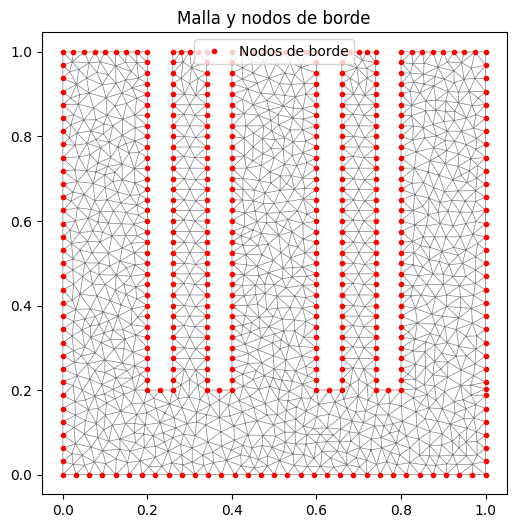

In [36]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# Triangulación para malla
triang = mtri.Triangulation(m.verts[:,0], m.verts[:,1], triangles=m.connectivity)

# Graficar malla
plt.figure(figsize=(6,6))
plt.triplot(triang, color='gray', linewidth=0.5)

# Agregar nodos de borde en rojo
boundary_nodes = find_boundary_nodes(m.connectivity.astype(int))
boundary_coords = m.verts[boundary_nodes]
plt.plot(boundary_coords[:,0], boundary_coords[:,1], 'ro', markersize=3, label="Nodos de borde")

plt.axis('equal')
plt.legend()
plt.title("Malla y nodos de borde")
plt.show()

In [27]:
~boundary_mask

array([ True,  True,  True, ...,  True, False, False])

In [ ]:
k = 0
for j in boundary_mask :
  if j == True :
    k += 1
k

896

In [ ]:
k = 0
for j in ~boundary_mask :
  if j == True :
    k += 1
k

393

In [53]:
eigfuncs

array([[-0.78664597,  1.32474732],
       [-0.78664597,  1.3246511 ],
       [-0.78664597,  0.61078831],
       ...,
       [-0.78664597,  0.73456897],
       [-0.78664597,  0.06037381],
       [-0.78664597,  0.71938781]])

In [58]:
eigfuncs[np.array([0,1287,2])]


array([[-0.78664597,  1.32474732],
       [-0.78664597,  0.06037381],
       [-0.78664597,  0.61078831]])

In [37]:
V = eigfuncs[~boundary_mask]
V

array([[-0.78664597,  1.32474732, -1.06133198, ..., -0.87655818,
         0.56210249, -0.22441066],
       [-0.78664597,  1.3246511 , -1.06120094, ..., -0.87005034,
         0.55684552, -0.20960593],
       [-0.78664597,  0.61078831, -0.15441306, ...,  0.19611928,
        -0.20928513,  1.04510913],
       ...,
       [-0.78664597, -0.75481305,  0.52397711, ...,  1.26014079,
         2.40143201,  1.47588174],
       [-0.78664597,  0.75697122,  0.51323374, ...,  1.26369659,
        -2.43691551,  1.48788925],
       [-0.78664597,  0.73456897, -0.30152438, ...,  0.68846115,
        -0.11018941, -0.94265755]])

In [ ]:
V.shape

(393, 50)

1. boundary_mask : true si es nodo interno
2. ~boundary_mask : true si es nodo borde
3. V = eigfuncs[~boundary_mask] : vectores propios en el borde

In [64]:
# ~boundary_mask : arreglo que te dice True si es borde , False si es interior.
# V = eigfuncs[~boundary_mask]
Y_true = np.array(mvtu.point_data['f_937']) # extraido del github son las soluciones conocidas

idx_c = np.where(boundary_mask)[0] # indices interiores totales
Y = Y_true[~boundary_mask] # valores reales en el borde
V = eigfuncs[~boundary_mask] # vectores propios en el borde

sigma_y = Y.std()
mu_y = Y.mean()

Y = (Y - mu_y)/sigma_y

norm_const = {'mu_y': mu_y, 'sigma_y': sigma_y}

Bs = [] # Matriz de Gradiente u, por lo que yo veo no se utiliza dentro de la clase delta-PINNS

for e in range(m.connectivity.shape[0]):
    B, J = m.Bmatrix(e)
    Bs.append(np.dot(B.T, B)/J**2)

Bs = np.array(Bs)

In [91]:
Y.shape

(393,)

In [89]:
Y_true,Y_true.shape, Y , Y.shape

(array([0.61262367, 0.6126411 , 0.88299414, ..., 0.86782737, 0.86587736,
        0.85475172]),
 (1289,),
 array([-0.5936783 , -0.59356999,  1.08624254,  1.02932226, -1.72062181,
        -1.72082666,  1.03372418,  1.12402121, -0.54382176, -0.54386053,
         1.13957715,  1.08231352, -1.6911425 , -1.69102934,  1.10847233,
         1.26665738,  0.16700308,  0.23082298,  1.81324716,  1.81324716,
         0.08877032,  1.81324716,  0.71340365, -0.12940219,  0.82613341,
         1.81324716,  1.81324716,  0.51686851,  1.19304732, -0.3781272 ,
        -1.05247517, -1.01552437, -1.05251062, -1.01548853, -0.07372912,
        -0.07366133,  0.39125889, -0.38902792, -0.38898408, -1.49931834,
        -1.53099098, -1.49929394, -1.53101401,  0.29747524, -0.44071349,
         0.41492824,  0.41436179, -0.19073812, -0.23670213, -0.19069614,
        -0.23673771,  0.83422159,  0.35392541,  1.49010543, -0.2520385 ,
        -0.25205208, -1.33015527, -1.29625803, -1.33017488, -1.29623819,
        -0.30542648

In [ ]:
Y.shape , np.where(~boundary_mask)[0].shape

((393,), (393,))

In [ ]:
# Ejemplo: 5 vértices, donde los nodos borde son el 1 y 3 (0-based)
b_mask = np.array([True, True, False, True, True])

idx_c = np.where(b_mask)[0]
print(idx_c)  # Output: array([1, 3])

[0 1 3 4]


In [ ]:
# indices de los nodos internos

idx_c = np.where(boundary_mask)[0]
idx_c.shape

(896,)

In [ ]:
Y_true[~boundary_mask].shape   # valores en el borde

(393,)

In [45]:
eigfuncs[~boundary_mask].shape # vectores propios en el borde

(393, 10)

# Prueba para cargar datos(no considerar)

In [ ]:
import pickle

# Cargar el archivo .pkl
with open('datos_onda_bordeTop_fem.pkl', 'rb') as f:
    datos = pickle.load(f)

top_nodes = datos['top_nodes']
top_U = datos['top_U']

In [ ]:
top_nodes

array([391, 397, 367, 399, 369, 370, 403, 404, 407, 380, 383], dtype=int32)

# Definir red y entrenamiento

In [38]:
dataset = LaplacePINNGenerator(np.array(V), np.array(Y), eigfuncs, numlap, idx_c, batch_size=30)
model = LaplacePINN(eigfuncs, m.connectivity, Bs, norm_const)

# Setup architecture
init_key = random.PRNGKey(0)
layers = [n_eigs, 100,100,100, 1]
args = (layers,)
model.architecture(MLP, *args, init_key=init_key)

# Setup optimizer
saved_state = None
learning_rate = optimizers.exponential_decay(1e-3, decay_steps=100, decay_rate=0.99)
args = (learning_rate, model.loss)
model.optimizer(adam, *args, saved_state=saved_state)

# Setup logger
io_keys = ['loss','loss_u','loss_r']
log_keys = ['loss','loss_u','loss_r']
log_funs = [model.loss, model.loss_u, model.loss_r]
args = (io_keys, log_keys, log_funs)
model.logger(logger, *args, io_step = 200)

In [65]:
# Train # 10 vec

#validation_data = (X_star, u_star)
model.train(dataset, nIter = 1, ntk_weights = False)

100%|██████████| 1/1 [00:00<00:00, 34.50it/s, loss=0.0004281058507107259, loss_u=0.0003993454890784109, loss_r=2.8760361632314994e-05]


# Graficos

In [66]:
opt_params = model.get_params(model.opt_state)
u_pred = model.predict(opt_params, eigfuncs)

MSE = np.mean(((Y_true - mu_y)/sigma_y - u_pred)**2)
plt.plot((Y_true - mu_y)/sigma_y , u_pred,'.')
#plt.scatter(Y , Y, c = 'r', zorder = 100, label = 'data')
plt.xlabel('valor de referencia de FEM')
plt.ylabel('predicción de la red')
plt.title('Comparación entre predición y solución de referencia, MSE = %f' % MSE )
print(MSE)
#plt.savefig('../output/coil_1.2_MM_chainrulegrad.png')

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (3,).

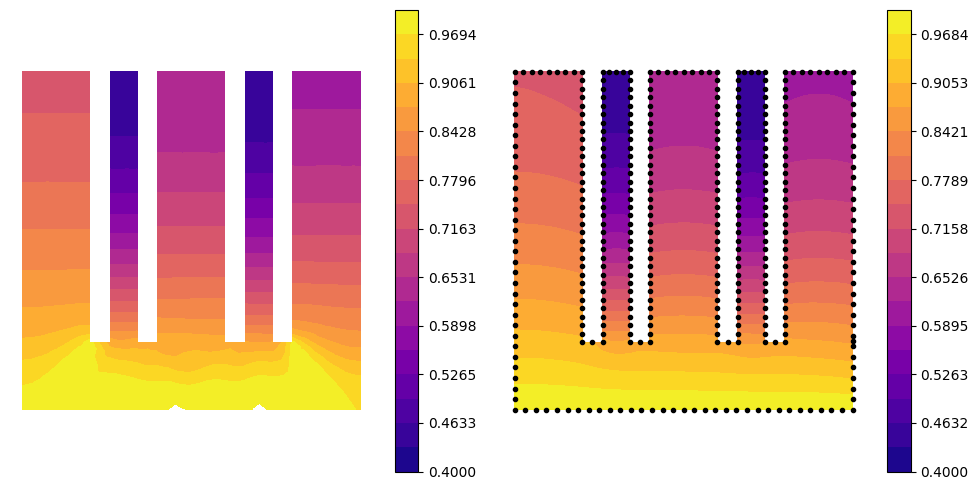

In [42]:
fig = plt.figure()
fig.set_size_inches((10,5))

plt.subplot(121)
plt.tricontourf(verts[:,0], verts[:,1], connectivity, u_pred*sigma_y + mu_y,  np.linspace(0.4,1.001,20), cmap = plt.cm.plasma)
plt.colorbar()
#plt.scatter(verts[idx_train,0], verts[idx_train,1])
plt.axis('equal')
plt.axis('off')

plt.subplot(122)
plt.tricontourf(verts[:,0], verts[:,1], connectivity, Y_true, np.linspace(0.4,1,20), cmap = plt.cm.plasma)
plt.colorbar()

plt.plot(verts[~boundary_mask,0], verts[~boundary_mask,1],'k.')
plt.axis('equal')
plt.axis('off')

plt.tight_layout()

#plt.savefig('../output/LaplacePINNs_numheat.pdf')